# Bitcoin cycles

Bitcoin prices in relation to halving cycles.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv
from btc_cycles import Bitcoin

load_dotenv()

False

## Bitcoin

`Bitcoin` is the main object.
Fetches data from the selected source, computes metrics (ATH and cycle progress).

*Available sources*:
- `cryptocompare`: [cryptocompare](https://www.cryptocompare.com/) requires API key
- `coinmarketcap`: [coinmarketcap](https://coinmarketcap.com/) requires API key
- `coinmarketcap-free`: [coinmarketcap](https://coinmarketcap.com/) **broken legacy API**, still available hoping for a fix ([see here](https://github.com/guptarohit/cryptoCMD/issues/86)).

*Arguments*
- `currency` (str) : currency. Defaults to USD.
- `source` (str) : source of price data
- `api_key` (str) : API key to selected source

*Attributes*
- `prices` (pd.DataFrame) : pandas dataframe of prices
- `halvings` (pd.DataFrame) : pandas dataframe of halvings data
- `predicted_halving_block` (int): block of next halving
- `predicted_halving_date` (datetime): predicted date of next halving 

In [3]:
btc = Bitcoin(
    source="cryptocompare",  # "coinmarketcap", "cryptocompare"
    api_key=os.getenv("CRYPTOCOMPARE_API_KEY"),  # only for cryptocompare, coinmarketcap
)

In [4]:
print(
    f"Next halving (block {btc.predicted_halving_block}) is predicted on {btc.predicted_halving_date}"
)

Next halving (block 1050000) is predicted on 2028-03-31 03:58:44+00:00


In [5]:
btc.halvings.head(10)

,block,reward,Date,cycle_length,cycle_id
0,0,50,2009-01-03 00:00:00+00:00,1425.0,1
1,210000,25.0,2012-11-28 00:00:00+00:00,1319.0,2
2,420000,12.5,2016-07-09 00:00:00+00:00,1402.0,3
3,630000,6.25,2020-05-11 00:00:00+00:00,1440.0,4
4,840000,3.125,2024-04-20 12:09:27+00:00,1440.0,5
5,1050000,1.5625,2028-03-31 03:58:44+00:00,NaN,6
6,1260000,0.78125,NaT,NaN,7
7,1470000,0.390625,NaT,NaN,8
8,1680000,0.195312,NaT,NaN,9
9,1890000,0.097656,NaT,NaN,10


In [6]:
btc.halvings["cycle_length_2"] = btc.halvings["Date"].diff().dt.days

In [7]:
import datetime as dt

In [8]:
btc.halvings

,block,reward,Date,cycle_length,cycle_id,cycle_length_2
0,0,50,2009-01-03 00:00:00+00:00,1425.0,1,NaN
1,210000,25.0,2012-11-28 00:00:00+00:00,1319.0,2,1425.0
2,420000,12.5,2016-07-09 00:00:00+00:00,1402.0,3,1319.0
3,630000,6.25,2020-05-11 00:00:00+00:00,1440.0,4,1402.0
4,840000,3.125,2024-04-20 12:09:27+00:00,1440.0,5,1440.0
5,1050000,1.5625,2028-03-31 03:58:44+00:00,NaN,6,1440.0
6,1260000,0.78125,NaT,NaN,7,NaN
7,1470000,0.390625,NaT,NaN,8,NaN
8,1680000,0.195312,NaT,NaN,9,NaN
9,1890000,0.097656,NaT,NaN,10,NaN


In [9]:
btc.prices

,Date,Close,block,reward,cycle_length,cycle_id,Halving,ATH,distance_ath_perc,cycle_progress
0,2010-07-17 00:00:00+00:00,0.04951,0.0,50.000,1425.0,1.0,2009-01-03 00:00:00+00:00,0.04951,0.000000,0.392982
1,2010-07-18 00:00:00+00:00,0.08584,0.0,50.000,1425.0,1.0,2009-01-03 00:00:00+00:00,0.08584,0.000000,0.393684
2,2010-07-19 00:00:00+00:00,0.08080,0.0,50.000,1425.0,1.0,2009-01-03 00:00:00+00:00,0.08584,-0.058714,0.394386
3,2010-07-20 00:00:00+00:00,0.07474,0.0,50.000,1425.0,1.0,2009-01-03 00:00:00+00:00,0.08584,-0.129310,0.395088
4,2010-07-21 00:00:00+00:00,0.07921,0.0,50.000,1425.0,1.0,2009-01-03 00:00:00+00:00,0.08584,-0.077237,0.395789
...,...,...,...,...,...,...,...,...,...,...
5323,2025-02-11 00:00:00+00:00,95781.05000,840000.0,3.125,1440.0,5.0,2024-04-20 12:09:27+00:00,106155.61000,-0.097730,0.205556
5324,2025-02-12 00:00:00+00:00,97874.61000,840000.0,3.125,1440.0,5.0,2024-04-20 12:09:27+00:00,106155.61000,-0.078008,0.206250
5325,2025-02-13 00:00:00+00:00,96632.78000,840000.0,3.125,1440.0,5.0,2024-04-20 12:09:27+00:00,106155.61000,-0.089706,0.206944
5326,2025-02-14 00:00:00+00:00,97508.71000,840000.0,3.125,1440.0,5.0,2024-04-20 12:09:27+00:00,106155.61000,-0.081455,0.207639


## Plots

The method `plot` returns a `matplotlib.Figure` radial chart of the prices.

Arguments:
- `from_date` (str or datetime): date from which data is plotted. Some sources offers unlimited historical data and some filtering might be needed.
- `theme` (str or dict): theme of the plot. Default is `light`, or `dark` for dark mode. Custom themes can be passed as a dictionary. Colors can also be customized singularly.

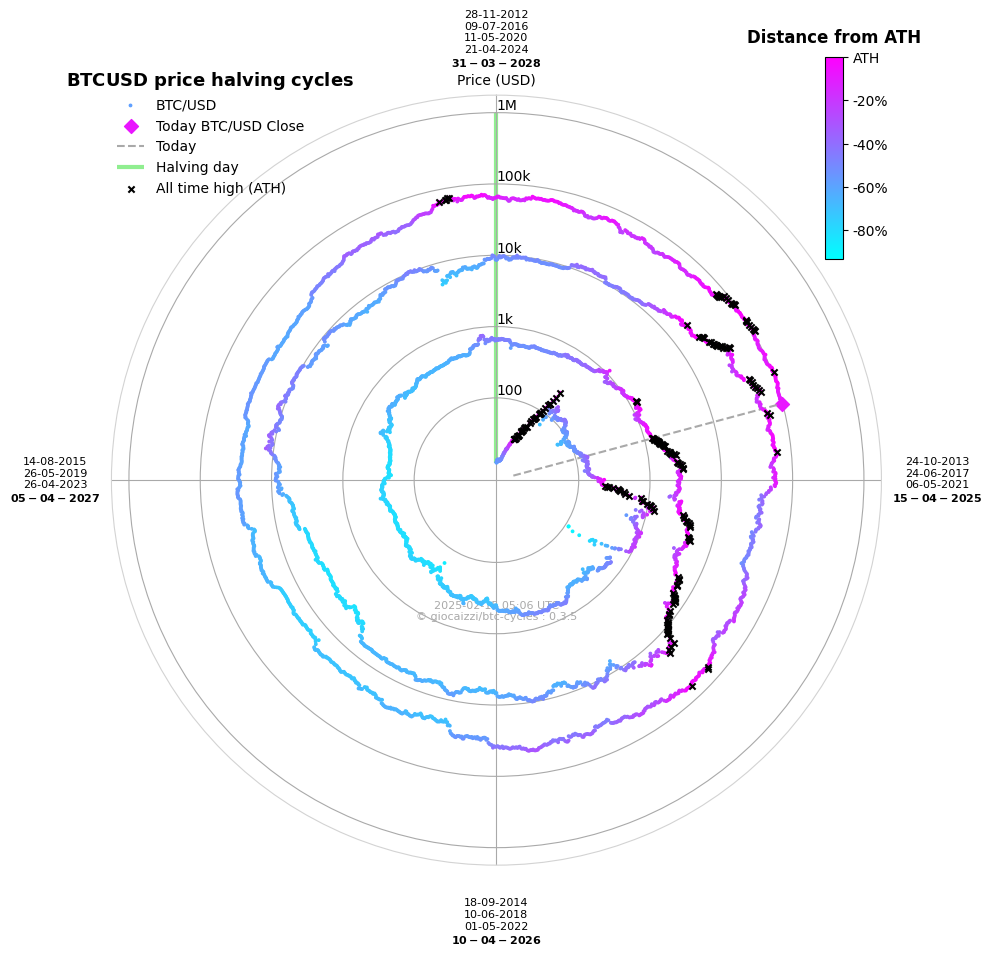

In [10]:
fig = btc.plot(
    from_date="2012-11-28",  # start date
    # theme="dark",  # dark or light, or dict with custom colors.
    # theme = {
    #     "now_line": "red"
    # },
)
# # fig is a matplotlib figure object
fig.savefig("bitcoin.png")